### 封装好的split工具

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np

learning_rate = 1e-4
keep_prob_rate = 0.7  #
max_epoch = 10
BATCH_SIZE = 32

DOWNLOAD_MNIST = False

from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
import numpy as np

def load_dataset(folder_path, ratio=0.7):
    # folder_path 表示数据放的路径
    train_data = []
    test_data = []

    ##随机数种设定，为了每次运行程序，随机数都相同
    random.seed(1)

    ##将类别名统一以数字代替
    label_dict = {label: i for i, label in enumerate(os.listdir(folder_path))}
    print(label_dict)
    ##按radio:1-radio的比例划分出训练集和测试集
    for label in os.listdir(folder_path):
        img_paths = [img_path
                     for img_path in os.listdir(os.path.join(folder_path, label))]

        random.shuffle(img_paths)
        train_data += [(os.path.join(folder_path, label, img), label_dict[label])
                       for img in img_paths[:int(len(img_paths) * ratio)]]
        test_data += [(os.path.join(folder_path, label, img), label_dict[label])
                      for img in img_paths[int(len(img_paths) * ratio):]]

    # transforms.Compose 表示数据预处理
    train_dataset = dataset(
        data=train_data,
        transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )
    test_dataset = dataset(
        data=test_data,
        transform=transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )

    # get_loader获取数据的迭代器
    # shuffle表示是否打乱顺序
    # drop_last表示是否丢掉batch_size不等于BATCH_SIZE的数据
    # num_workers表示计算核数

    # train_dataloader = train_dataset.get_loader(
    #     batch_size=BATCH_SIZE,
    #     shuffle=True,
    #     drop_last=True,
    #     num_workers=4
    # )

    #   使用for循环获取每次batch_size大小的数据
    # for imgs, labels in train_dataloader:
    #     print(imgs.shape, labels.shape)

    return train_dataset, test_dataset


class dataset(Dataset):
    def __init__(self, data, transform=None):
        super(dataset, self).__init__()
        self.data = data
        self.transform = transform

    def get_loader(self, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=0):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=num_workers,
                          drop_last=drop_last)

    def __len__(self):
        ##数据总长度
        return len(self.data)

    def __getitem__(self, idx):
        # 每次获取数据中的一条，idx表示数据的下标

        img = Image.open(self.data[idx][0]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.LongTensor([self.data[idx][1]])
        
        return img, label


### 分隔数据集

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import torch.optim as optim
import os
import json
import time

In [44]:
batch_size = 32
path = 'F:\\ECNU2020_2\\人工智能\\上机作业\\作业6\\CNN图像分类\\CNN图像分类\\animal\\animal'
save_path = 'F:\\ECNU2020_2\\人工智能\\上机作业\\作业6\\CNN图像分类\\CNN图像分类'
train_dataset, test_dataset=load_dataset(path, ratio=0.7)
train_loader = train_dataset.get_loader(batch_size=batch_size,
                                       shuffle = True,
                                       num_workers=0,
                                       drop_last=False)
test_loader = test_dataset.get_loader(batch_size=batch_size,
                                       shuffle = True,
                                       num_workers=0,
                                       drop_last=False)
test_num = len(test_dataset.data)

{'butterfly': 0, 'cat': 1, 'chicken': 2, 'dog': 3, 'horse': 4}


### 定义模型
这里做了一个区分，把_2的forward进行更改从而实现输出图像操作
### AlexNet(2012)

In [4]:
class AlexNet(nn.Module):
    def __init__(self,num_classes=1000):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            #3-48
            nn.Conv2d(in_channels=      3,  
                      out_channels=     48,
                      kernel_size=      11,
                      stride=           4,
                      padding=          2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=      48,  
                      out_channels=     128,
                      kernel_size=      5,
                      padding=          2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=      128,  
                      out_channels=     192,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=      192,  
                      out_channels=     192,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=      192,  
                      out_channels=     128,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128*6*6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,2048),
            nn.ReLU(inplace = True),
            nn.Linear(2048,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,start_dim=1)
        x = self.classifier(x)
        return x
    

In [5]:
class AlexNet_2(nn.Module): #作图返回forward
    def __init__(self,num_classes=1000):
        super(AlexNet_2,self).__init__()
        self.features = nn.Sequential(
            #3-48
            nn.Conv2d(in_channels=      3,  
                      out_channels=     48,
                      kernel_size=      11,
                      stride=           4,
                      padding=          2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=      48,  
                      out_channels=     128,
                      kernel_size=      5,
                      padding=          2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=      128,  
                      out_channels=     192,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=      192,  
                      out_channels=     192,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=      192,  
                      out_channels=     128,
                      kernel_size=      3,
                      padding=          1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128*6*6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,2048),
            nn.ReLU(inplace = True),
            nn.Linear(2048,num_classes)
        )
        
    def forward(self,x):
        outputs=[]
        for name,module in self.features.named_children():
            x = module(x)
            if name in ["0","3","6","10"]:
                outputs.append(x)
        return outputs

#### Resnet18

In [26]:
def make_layer(in_channel, out_channel, block_num, stride=1):
    shortcut = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 1, stride),
        nn.BatchNorm2d(out_channel))
    layers = list()
    layers.append(ResBlock(in_channel, out_channel, stride, shortcut))

    for i in range(1, block_num):
        layers.append(ResBlock(out_channel, out_channel))
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, shortcut=None):
        super(ResBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
        )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

class myResNet(nn.Module):
    def __init__(self,num_classes = 1000):
        super(myResNet, self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels=      3,  
                      out_channels=     64,
                      kernel_size=      7,
                      stride=           2,
                      padding=          3,
                      bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(True), nn.MaxPool2d(3, 2, 1))
        self.layer1 = make_layer(64, 64, 2)
        self.layer2 = make_layer(64, 128, 2, stride=2)
        self.layer3 = make_layer(128, 256, 2, stride=2)
        self.layer4 = make_layer(256, 512, 2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.classifier = nn.Sequential(nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.pre(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return out

In [34]:
class myResNet_2(nn.Module):
    def __init__(self,num_classes = 1000):
        super(myResNet_2, self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels=      3,  
                      out_channels=     64,
                      kernel_size=      7,
                      stride=           2,
                      padding=          3,
                      bias=False), 
            nn.BatchNorm2d(64),
            nn.ReLU(True), nn.MaxPool2d(3, 2, 1))
        self.layer1 = make_layer(64, 64, 2)
        self.layer2 = make_layer(64, 128, 2, stride=2)
        self.layer3 = make_layer(128, 256, 2, stride=2)
        self.layer4 = make_layer(256, 512, 2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.classifier = nn.Sequential(nn.Linear(512, num_classes))

    def forward(self,x):
        outputs=[]
        x = self.pre(x)
        x = self.layer1(x)
        outputs.append(x)
        x = self.layer2(x)
        outputs.append(x)
        x = self.layer3(x)
        outputs.append(x)
        x = self.layer4(x)
        outputs.append(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return outputs

### 训练与验证

In [22]:
def train(cpu=0,epoch_round=10,prt=1,NET = 'AlexNet',res = 18): #默认使用GPU,默认打印输出,Alexnet,如果是myresnet就是用自己实现的resnet
    if NET == 'ResNet':        
        if res==18:
            net = models.resnet18(pretrained=False,num_classes=5)
        elif res==34:
            net = models.resnet34(pretrained=False,num_classes=5)
        elif res==50:
            net = models.resnet50(pretrained=False,num_classes=5)
        elif res==101:
            net = models.resnet101(pretrained=False,num_classes=5)
        elif res==152:
            net = models.resnet152(pretrained=False,num_classes=5)
        else:
            net = models.resnet18(pretrained=False,num_classes=5)
    elif NET == 'myResNet':
        net = myResNet(num_classes = 5)
        res = ''
    else:
        net = AlexNet(num_classes=5)
        res = ''
    all_t=0
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(),lr=0.0002)
    best_acc = 0.0
    ret = []#设立一个参数，是准确率的曲线
    device = torch.device("cuda:0")#if torch.cuda.is_available() else "cpu")
    if cpu == 1:
        device = "cpu"
    for epoch in range(epoch_round):
        net.to(device)
        net.train()
        running_loss = 0.0
        t1 = time.time()
        for step,data in enumerate(train_loader,start = 0):
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze()
            optimizer.zero_grad()
            outputs= net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            rate = (step+1)/len(train_loader)
            if prt:
                print("\r",int(rate*100),"%          ",running_loss,end="")
        if (epoch_round<=20 or epoch%10 == 0) and prt:
            print()
            if cpu==1:
                print("CPU",end=" ")
            else:
                print("GPU",end=" ")     
            print("Time:",time.time()-t1)
        all_t+=time.time()-t1
        #验证集
        net.eval()
        acc = 0.0
        with torch.no_grad():
            for test_data in test_loader:
                test_images,test_labels = test_data
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)
                test_labels = test_labels.squeeze()
                outputs = net(test_images)
                predict_y = torch.max(outputs,dim=1)[1]
                acc+=(predict_y == test_labels).sum().item()
            test_accurate = acc/test_num
            ret.append(test_accurate)
            if test_accurate>best_acc:
                best_acc = test_accurate
                if NET == 'AlexNet':
                    torch.save(net.state_dict(),save_path+'\\Alexnet.pth')
                if NET == 'myResNet':
                    torch.save(net.state_dict(),save_path+'\\ResNet18.pth')
            if (epoch_round<=20 or epoch%10 == 0) and prt:
                print('[epoch %d] train loss: %.3f test accuracy: %.3f'%
                     (epoch+1,running_loss/step,test_accurate))
    print(NET,res,"=> BEST ACC:",best_acc,"---time: ",all_t,"---FIN.")
    return ret

 100 %           46.61764073371887
GPU Time: 5.757894992828369
[epoch 1] train loss: 1.457 test accuracy: 0.311
 100 %           31.745541214942932
GPU Time: 4.5697760581970215
[epoch 11] train loss: 0.992 test accuracy: 0.511
 100 %           26.173586517572403
GPU Time: 4.504949331283569
[epoch 21] train loss: 0.818 test accuracy: 0.576
 100 %           24.317575186491013myResNet  => BEST ACC: 0.7022222222222222 ---time:  113.20448684692383 ---FIN.
 100 %           51.373220562934875
GPU Time: 2.4115488529205322
[epoch 1] train loss: 1.605 test accuracy: 0.378
 100 %           39.752824306488046
GPU Time: 2.4584240913391113
[epoch 11] train loss: 1.242 test accuracy: 0.469
 100 %           35.810770630836494
GPU Time: 2.4614157676696777
[epoch 21] train loss: 1.119 test accuracy: 0.500
 100 %           32.716260790824896AlexNet  => BEST ACC: 0.54 ---time:  61.43566083908081 ---FIN.


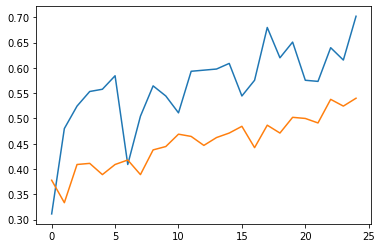

In [8]:
#round = 25,观察对比myResNet和AlexNet的精度以及运算过程的精度情况
rounds = 25
ret1 = train(0,rounds,1,"myResNet",1)
ret2 = train(0,rounds,1,"AlexNet",1)
plt.figure()
x=[i for i in range(rounds)]
plt.plot(x,ret1,ret2)

In [9]:
#在round = 25，batch_size=32时进行resnet各算法对比并关注层数的关系
rounds = 25
res = [18,34,50,101] #经测试，152过深，显存不足以支持。
for i in res:
    train(0,rounds,0,"ResNet",i)

ResNet 18 => BEST ACC: 0.6866666666666666 ---time:  110.39004349708557 ---FIN.
ResNet 34 => BEST ACC: 0.6644444444444444 ---time:  150.573233127594 ---FIN.
ResNet 50 => BEST ACC: 0.6288888888888889 ---time:  239.49761319160461 ---FIN.
ResNet 101 => BEST ACC: 0.6 ---time:  379.16691851615906 ---FIN.


### 特征输出

AlexNet  => BEST ACC: 0.5177777777777778 ---time:  61.52144145965576 ---FIN.
AlexNet_2(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out

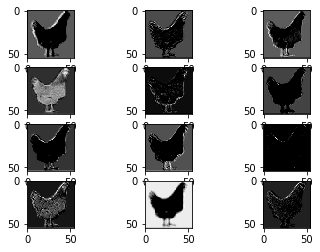

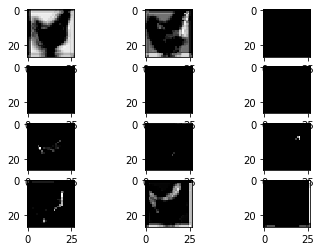

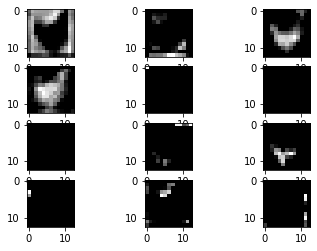

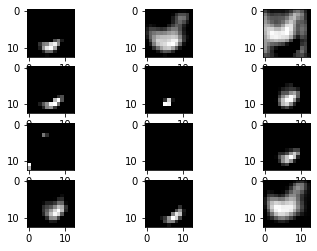

In [18]:
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

ret = train(0,25,0,'AlexNet',1)
model = AlexNet_2(num_classes=5)
model2 = AlexNet(num_classes=5)
model.load_state_dict(torch.load(save_path+'\\Alexnet.pth'))
model2.load_state_dict(torch.load(save_path+'\\Alexnet.pth'))
print(model)

imgpath = 'F:\\ECNU2020_2\\人工智能\\上机作业\\作业6\\CNN图像分类\\CNN图像分类\\predict_2.jpeg'
img = Image.open(imgpath)
img = data_transform(img)
img = torch.unsqueeze(img,dim = 0)

out_put = model(img)
out_put2 = model2(img)
print(out_put2)
for feature_map in out_put:
    im = np.squeeze(feature_map.detach().numpy())
    im = np.transpose(im,[1,2,0])
    plt.figure()
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(im[:,:,i],cmap='gray')
    plt.show()

myResNet_2(
  (pre): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (right): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  

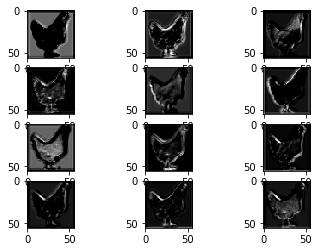

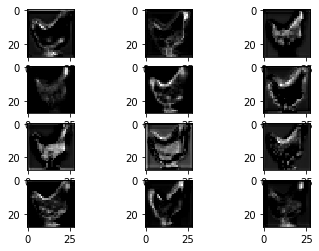

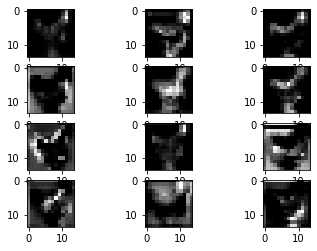

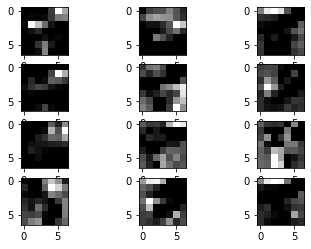

In [35]:
data_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#ret = train(0,25,0,'myResNet',1)
model = myResNet_2(num_classes=5)
model2 = myResNet(num_classes=5)
model.load_state_dict(torch.load(save_path+'\\ResNet18.pth'))
model2.load_state_dict(torch.load(save_path+'\\ResNet18.pth'))
print(model)
imgpath = 'F:\\ECNU2020_2\\人工智能\\上机作业\\作业6\\CNN图像分类\\CNN图像分类\\predict_2.jpeg'
img = Image.open(imgpath)
img = data_transform(img)
img = torch.unsqueeze(img,dim = 0)

out_put = model(img)
out_put2 = model2(img)
print(out_put2)
for feature_map in out_put:
    im = np.squeeze(feature_map.detach().numpy())
    im = np.transpose(im,[1,2,0])
    plt.figure()
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(im[:,:,i],cmap='gray')
    plt.show()

In [37]:
#batchsize=10
rounds = 10
ret1 = train(0,rounds,1,"AlexNet",1)

 100 %           156.4153047800064
GPU Time: 3.365994930267334
[epoch 1] train loss: 1.504 test accuracy: 0.373
 100 %           141.99879276752472
GPU Time: 3.40090274810791
[epoch 2] train loss: 1.365 test accuracy: 0.391
 100 %           142.26590985059738
GPU Time: 3.3659961223602295
[epoch 3] train loss: 1.368 test accuracy: 0.442
 100 %           135.77109026908875
GPU Time: 3.480689287185669
[epoch 4] train loss: 1.305 test accuracy: 0.371
 100 %           137.34853476285934
GPU Time: 3.4826838970184326
[epoch 5] train loss: 1.321 test accuracy: 0.442
 100 %           134.104036718606959 %           107.50752383470535
GPU Time: 3.4557557106018066
[epoch 6] train loss: 1.289 test accuracy: 0.429
 100 %           133.36101132631302
GPU Time: 3.435316801071167
[epoch 7] train loss: 1.282 test accuracy: 0.438
 100 %           133.9242502450943
GPU Time: 3.4088809490203857
[epoch 8] train loss: 1.288 test accuracy: 0.358
 100 %           130.87318858504295
GPU Time: 3.370982646942138

In [39]:
#batchsize=25
rounds = 10
ret1 = train(0,rounds,1,"AlexNet",1)

 100 %           65.41870093345642
GPU Time: 2.6269733905792236
[epoch 1] train loss: 1.596 test accuracy: 0.387
 100 %           58.08558177947998
GPU Time: 2.641932725906372
[epoch 2] train loss: 1.417 test accuracy: 0.402
 100 %           54.066405773162848.075403690338135
GPU Time: 2.6917991638183594
[epoch 3] train loss: 1.319 test accuracy: 0.373
 100 %           55.286662220954895          3.710844039916992
GPU Time: 2.6309621334075928
[epoch 4] train loss: 1.348 test accuracy: 0.396
 100 %           54.67899143695831 40.964046597480774
GPU Time: 2.6150050163269043
[epoch 5] train loss: 1.334 test accuracy: 0.398
 100 %           53.30600297451019
GPU Time: 2.5671327114105225
[epoch 6] train loss: 1.300 test accuracy: 0.436
 100 %           52.55356812477112
GPU Time: 2.5691277980804443
[epoch 7] train loss: 1.282 test accuracy: 0.442
 100 %           52.491437673568726
GPU Time: 2.6529037952423096
[epoch 8] train loss: 1.280 test accuracy: 0.429
 100 %           52.026782333850

In [41]:
#batchsize=32
rounds = 10
ret1 = train(0,rounds,1,"AlexNet",1)

 100 %           51.53621697425842
GPU Time: 2.579101085662842
[epoch 1] train loss: 1.611 test accuracy: 0.378
 100 %           43.78884780406952
GPU Time: 2.8035006523132324
[epoch 2] train loss: 1.368 test accuracy: 0.353
 100 %           43.93908405303955
GPU Time: 2.540205717086792
[epoch 3] train loss: 1.373 test accuracy: 0.422
 100 %           41.28872764110565
GPU Time: 2.4943277835845947
[epoch 4] train loss: 1.290 test accuracy: 0.378
 100 %           42.053831577301025
GPU Time: 2.4713895320892334
[epoch 5] train loss: 1.314 test accuracy: 0.351
 100 %           41.76091933250427
GPU Time: 2.4743807315826416
[epoch 6] train loss: 1.305 test accuracy: 0.433
 100 %           41.15527904033661
GPU Time: 2.4624135494232178
[epoch 7] train loss: 1.286 test accuracy: 0.440
 100 %           41.28226548433304
GPU Time: 2.4973201751708984
[epoch 8] train loss: 1.290 test accuracy: 0.460
 100 %           40.295482993125916
GPU Time: 2.6718528270721436
[epoch 9] train loss: 1.259 test

In [43]:
#batchsize=50
rounds = 10
ret1 = train(0,rounds,1,"AlexNet",1)

 100 %           33.06675052642822
GPU Time: 2.400578022003174
[epoch 1] train loss: 1.653 test accuracy: 0.229
 100 %           29.59605872631073
GPU Time: 2.4025726318359375
[epoch 2] train loss: 1.480 test accuracy: 0.378
 100 %           27.97597062587738
GPU Time: 2.38162899017334
[epoch 3] train loss: 1.399 test accuracy: 0.411
 100 %           28.02182638645172
GPU Time: 2.400578737258911
[epoch 4] train loss: 1.401 test accuracy: 0.396
 100 %           26.961715936660767
GPU Time: 2.3566956520080566
[epoch 5] train loss: 1.348 test accuracy: 0.302
 100 %           27.532634496688843
GPU Time: 2.354701280593872
[epoch 6] train loss: 1.377 test accuracy: 0.373
 100 %           27.376772165298462
GPU Time: 2.3846213817596436
[epoch 7] train loss: 1.369 test accuracy: 0.347
 100 %           25.996907591819763
GPU Time: 2.356696128845215
[epoch 8] train loss: 1.300 test accuracy: 0.393
 100 %           26.133992791175842
GPU Time: 2.395591974258423
[epoch 9] train loss: 1.307 test a

 100 %           51.526464223861694
GPU Time: 2.504297971725464
[epoch 1] train loss: 1.610 test accuracy: 0.351
 100 %           40.299273431301126
GPU Time: 2.4753780364990234
[epoch 11] train loss: 1.259 test accuracy: 0.444
 100 %           37.656023383140564
GPU Time: 2.5342209339141846
[epoch 21] train loss: 1.177 test accuracy: 0.489
 100 %           32.107383668422734
GPU Time: 2.479367733001709
[epoch 31] train loss: 1.003 test accuracy: 0.618
 100 %           27.848536193370824
GPU Time: 2.461416482925415
[epoch 41] train loss: 0.870 test accuracy: 0.636
 100 %           24.622782796621323
GPU Time: 2.4773733615875244
[epoch 51] train loss: 0.769 test accuracy: 0.662
 100 %           18.839892536401756
GPU Time: 2.48036527633667
[epoch 61] train loss: 0.589 test accuracy: 0.693
 100 %           17.993737667798996
GPU Time: 2.4913361072540283
[epoch 71] train loss: 0.562 test accuracy: 0.736
 100 %           15.028421610593796
GPU Time: 2.479367733001709
[epoch 81] train loss:

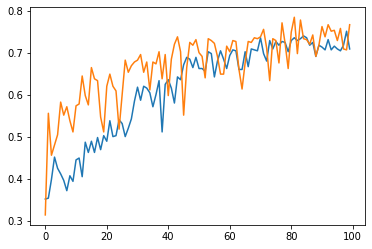

In [45]:
#batchsize=32
rounds = 100
ret1 = train(0,rounds,1,"AlexNet",1)
ret2 = train(0,rounds,1,"myResNet",1)
plt.figure()
x=[i for i in range(rounds)]
plt.plot(x,ret1,ret2)